In [1]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize
!pip install emcee
!pip install corner
import emcee
import seaborn as sns
import corner
import pymc3 as pm

     |████████████████████████████████| 51kB 6.5MB/s 


In [2]:
"""
Funciones de la temperatura 
Sky

"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf


In [3]:
from google.colab import files
uploaded=files.upload()

Saving figure1_plotdata.csv to figure1_plotdata.csv


In [4]:
names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])

In [5]:
ds=pd.read_csv('figure1_plotdata.csv',sep=',')
ds.head()
ds2=ds[ds.iloc[:,2]>1.0] 

#Modelo pyemcee con distribuciones Gausianas

In [ ]:
d1=ds2.iloc[:,0] # Valores de frecuencia [Mhz]
d2=ds2.iloc[:,2] # Valores de la temperatura [Mk]

#v=d1.freq-d1.freq.mean()/d1.freq.std()
v=d1#.freq
vc=78.0

with pm.Model() as pred_model:
    vc=78.01
    a0=pm.Normal('a0',mu=2006,sd=10)
    a1=pm.Normal('a1',mu=-720,sd=40)
    a2=pm.Normal('a2',mu=1010,sd=100)
    a3=pm.Normal('a3',mu=-750,sd=60)
    a4=pm.Normal('a4',mu=-175,sd=16)
#    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
    A=pm.Normal('A',mu=1.12,sd=0.12)
    v0=pm.Normal('v0',mu=77.9,sd=0.2)
    w=pm.Normal('w',mu=20.75,sd=0.5)
    tau=pm.Normal('tau',mu=3.6,sd=2.5)
#    T21=-A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*(np.log10(-1/tau*np.log10((1+np.e**-tau)/2))))))/(1-np.e**-tau)
    B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
    mu=pm.Deterministic('mu',a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau))))
#    mu=pm.Deterministic('mu',T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
    trace_pred=pm.sample(2500,tune=2500)
filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
vnames=np.array(trace_pred.varnames)[filt1&filt2] # arreglo con los nombres
trace_array=np.array([trace_pred[i] for i in vnames]).T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]
100%|██████████| 5000/5000 [11:09<00:00,  7.46it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
mean_pars=trace_array.mean(axis=0)
pars=mean_pars[0:9]
print('los valores de las constantes son\n ')
for i in range( len(names)):
  print( '    ',  names[i], '  es :  ',pars[i])


los valores de las constantes son
 
     a0   es :   1949.9060762522797
     a1   es :   -435.975309604228
     a2   es :   1356.8725188194085
     a3   es :   -104.77127687932087
     a4   es :   -263.76808910429634
     A   es :   0.8414497465727993
     v0   es :   77.89789647023531
     w   es :   20.90282481648146
     tau   es :   1.5446039361032504


In [ ]:
plt.figure(figsize=(7,5))
plt.plot(Dat[:,0],T_sky(Dat[:,0],*pars))
plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.plot(Dat[:,0],T_sky(Dat[:,0],*pars),color='darkred',label='Ajuste pyemcee')
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')
plt.grid()
plt.legend()

NameError: ignored

<Figure size 504x360 with 0 Axes>

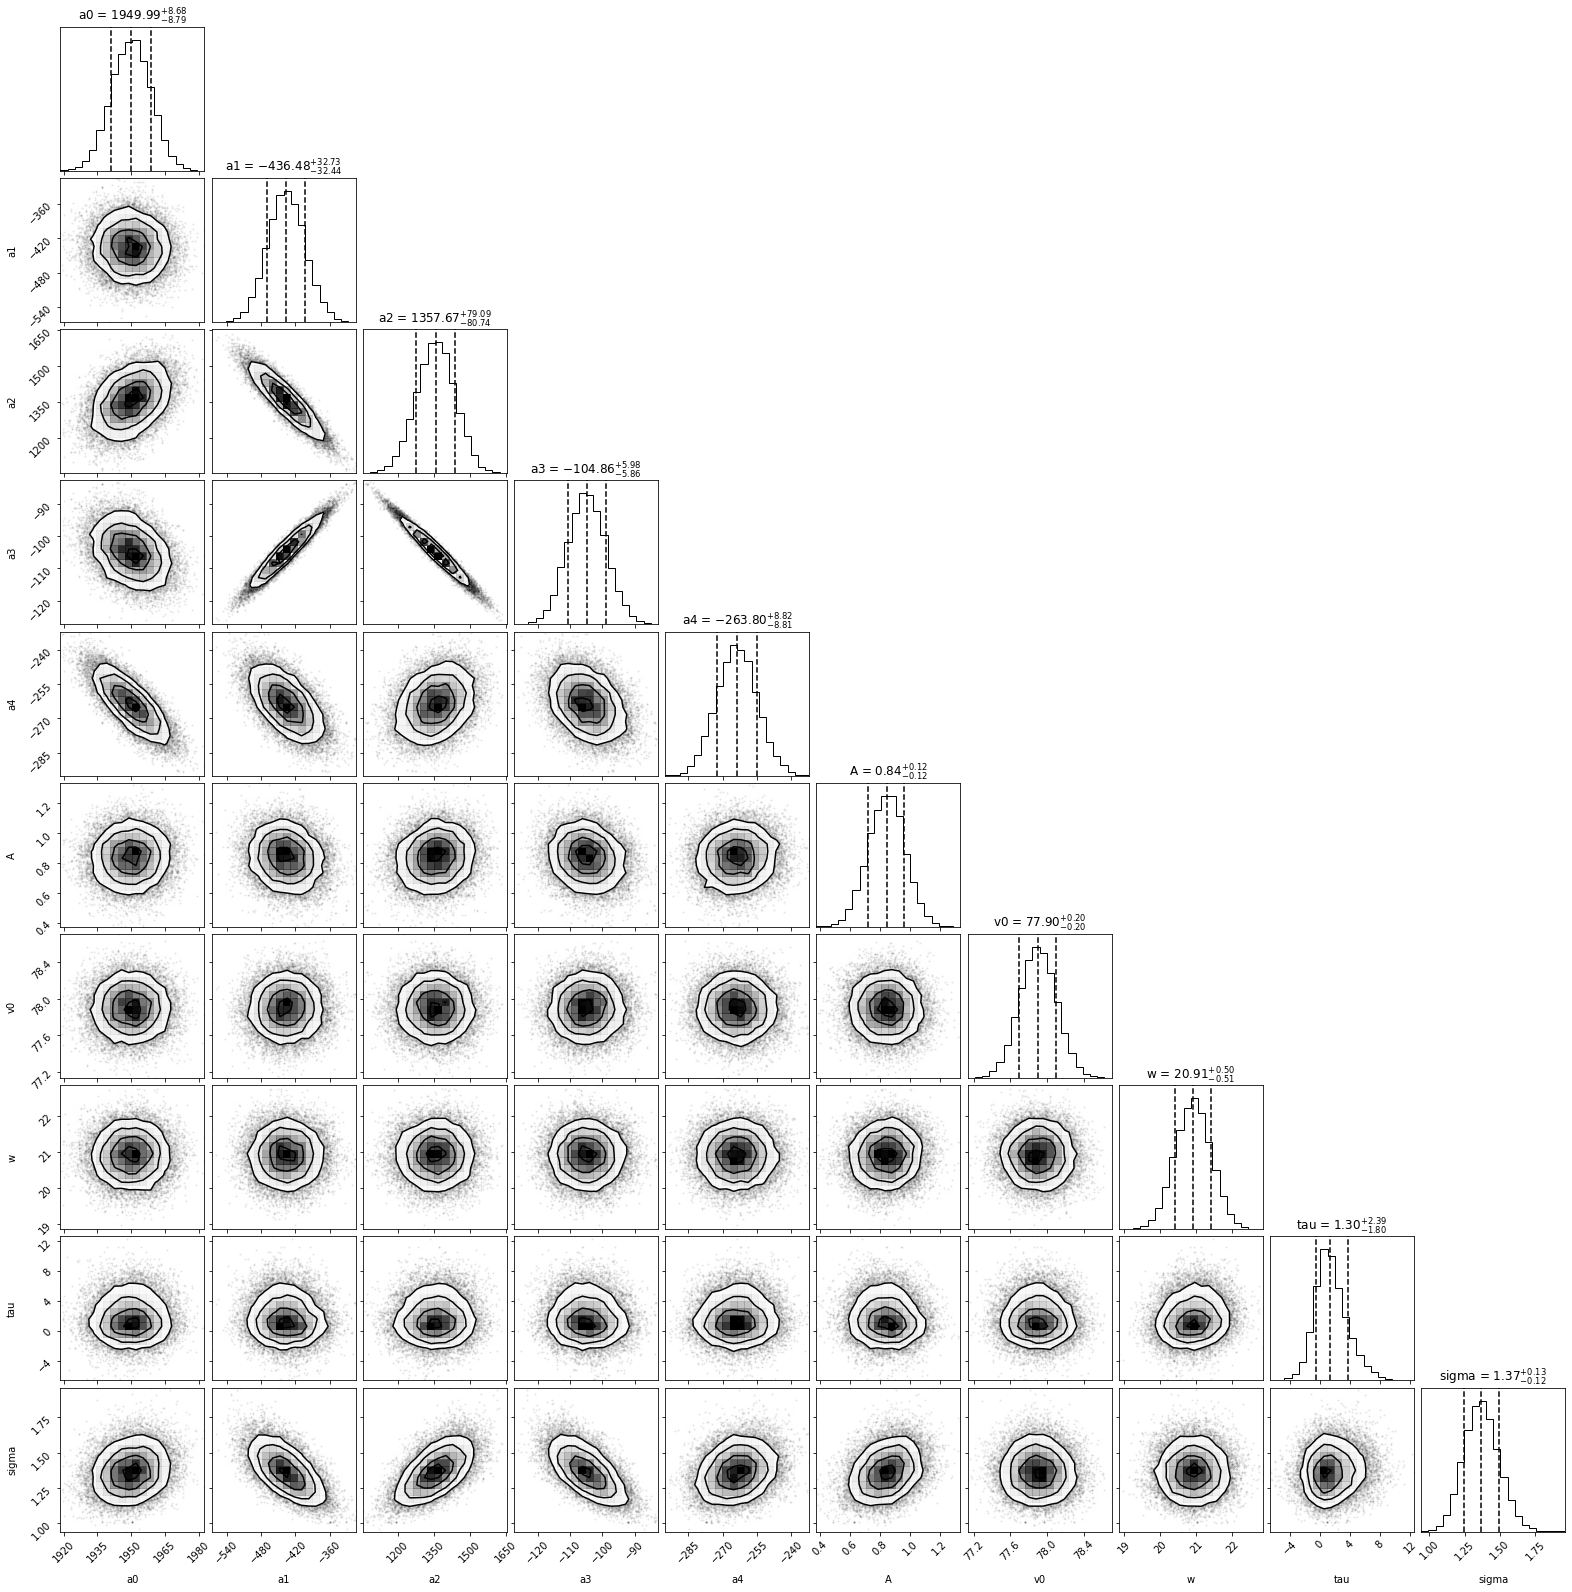

In [ ]:
corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],show_titles=True) 
plt.show()

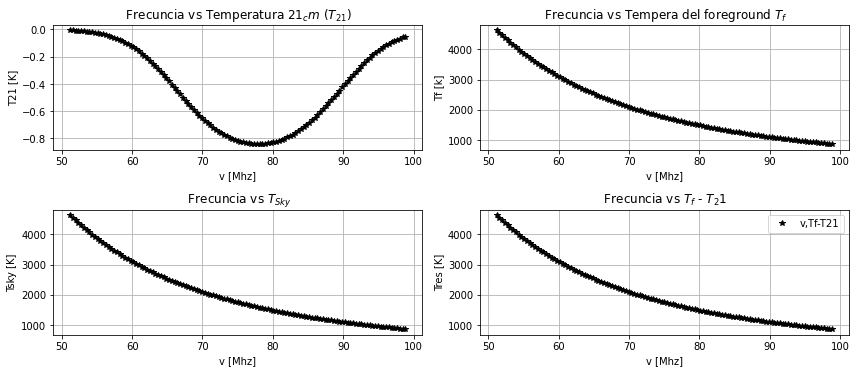

In [ ]:
a0,a1,a2,a3,a4,A,v0,w,tau=pars
plt.figure(figsize=(12,10))
plt.subplot(4,2,1)
plt.plot(v, T_21(v,A,v0,w,tau),'k*')
plt.title(' Frecuncia vs Temperatura $21_cm$ ($T_{21}$) ')
plt.xlabel('v [Mhz]')
plt.ylabel('T21 [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,2)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4),'k*')
plt.title(' Frecuncia vs Tempera del foreground $T_f$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tf [k]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,3)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4)+ T_21(v,A,v0,w,tau),'k*')
plt.title(r' Frecuncia vs $T_{Sky}$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tsky [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,4)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4)- T_21(v,A,v0,w,tau),'k*',label='v,Tf-T21')
plt.title(' Frecuncia vs $T_f$ - $T_21$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tres [K]')
plt.legend()
plt.tight_layout()
plt.grid()

## Modelo pyemcee usando distribuciones Gaussianas

In [7]:
d1=ds2.iloc[:,0] # Valores de frecuencia [Mhz]
d2=ds2.iloc[:,2] # Valores de la temperatura [Mk]

#v=d1.freq-d1.freq.mean()/d1.freq.std()
v=d1#.freq
vc=78.0

with pm.Model() as pred_model:
    vc=78.01
    a0=pm.Uniform('a0',lower=1500,upper=2500)
    a1=pm.Uniform('a1',lower=-1000,upper=-100)
    a2=pm.Uniform('a2',lower=500,upper=1400)
    a3=pm.Uniform('a3',lower=-1000,upper=-120)
    a4=pm.Uniform('a4',lower=100,upper=300)
#    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
    A=pm.Uniform('A',lower=0.0,upper=1.28)
    v0=pm.Uniform('v0',lower=76.7,upper=78.9)
    w=pm.Uniform('w',lower=15.6,upper=25.1)
    tau=pm.Uniform('tau',lower=0.8,upper=10.4)
#    T21=-A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*(np.log10(-1/tau*np.log10((1+np.e**-tau)/2))))))/(1-np.e**-tau)
    B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
    mu=pm.Deterministic('mu',a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau))))
#    mu=pm.Deterministic('mu',T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
    trace_pred_2=pm.sample(2500,tune=2500)
filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred_2.varnames])
filt2=np.array([np.logical_not('mu' in k) for k in trace_pred_2.varnames])
vnames=np.array(trace_pred_2.varnames)[filt1&filt2] # arreglo con los nombres
trace_array_2=np.array([trace_pred_2[i] for i in vnames]).T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]
100%|██████████| 5000/5000 [00:19<00:00, 260.51it/s]


In [8]:
mean_pars=trace_array_2.mean(axis=0)
pars=mean_pars[0:9]
print('los valores de las constantes son\n ')
for i in range( len(names)):
  print( '    ',  names[i], '  es :  ',pars[i])


los valores de las constantes son
 
     a0   es :   2023.970439831973
     a1   es :   -779.8047089844372
     a2   es :   1038.6724239786813
     a3   es :   -620.0148688889424
     a4   es :   199.9645053625342
     A   es :   1.1140445124414957
     v0   es :   78.01604811448902
     w   es :   19.303877206708805
     tau   es :   3.6058940737095764


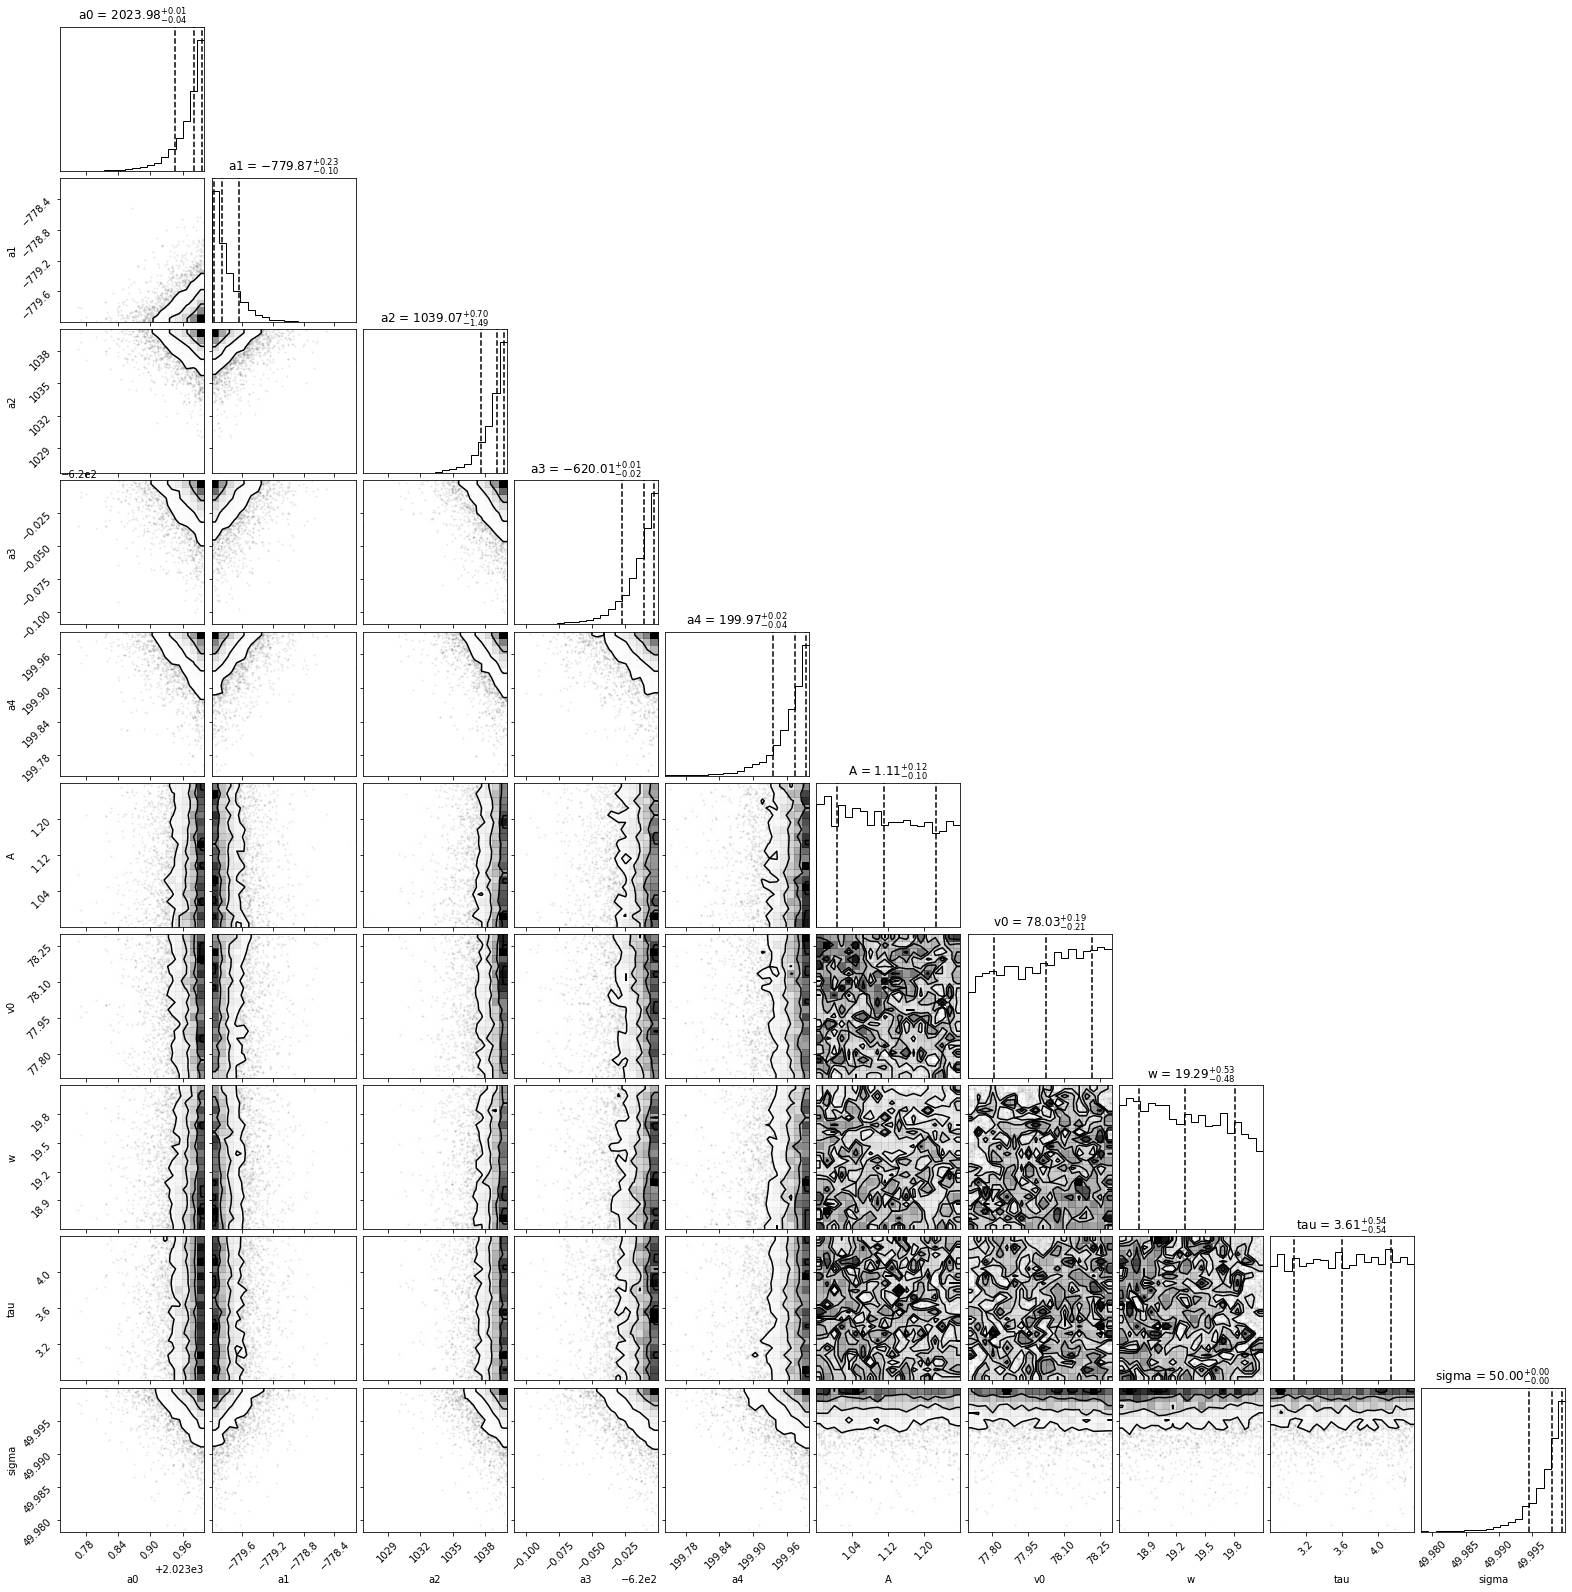

In [9]:
corner.corner(trace_array_2,labels=vnames,quantiles=[0.16, 0.5, 0.84],show_titles=True) 
plt.show()

##Tiempo de autocorrelación 

Autocorrelation time for ['a0' 'a1' 'a2' 'a3' 'a4' 'A' 'v0' 'w' 'tau']


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: ignored

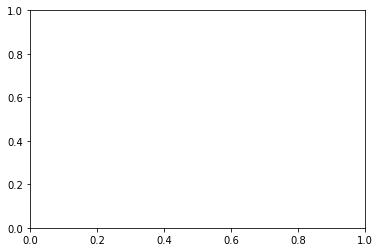

In [ ]:
# Estimate autocorrelation time of the MCMC sampling for the "best" model
print("Autocorrelation time for "+str(names))
for j in range(10):
    autocorr=[]
    for i in range(2500):
        autocorr.append(emcee.autocorr.integrated_time(trace_array_3[i][j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)
    print("Mean: ",autocorr.mean(),"Stdev: ",autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           names,
           scatterpoints=1,
           loc='upper right',
           ncol=10,
           fontsize=11)

In [ ]:
trace_array_3

array([[ 1.93722560e+03, -4.32832966e+02,  1.30465090e+03, ...,
         2.01194144e+01,  1.08091630e+00,  1.30582170e+00],
       [ 1.93472905e+03, -4.17499778e+02,  1.26471018e+03, ...,
         2.15400466e+01,  3.12669633e+00,  1.27679349e+00],
       [ 1.94478324e+03, -4.00178660e+02,  1.24327113e+03, ...,
         2.13849850e+01,  1.07255791e+00,  1.22717334e+00],
       ...,
       [ 1.96552161e+03, -4.27490793e+02,  1.43699485e+03, ...,
         2.07220245e+01, -2.38983613e-02,  1.28946463e+00],
       [ 1.97292126e+03, -4.50603919e+02,  1.42640579e+03, ...,
         2.11303720e+01,  3.60708400e-01,  1.35152809e+00],
       [ 1.97446998e+03, -4.28292990e+02,  1.46432121e+03, ...,
         2.09459862e+01,  1.34899566e+00,  1.39405877e+00]])

#Otro conjunto de cosntantes dan como resultado

In [6]:

d1=ds2.iloc[:,0] # Valores de frecuencia [Mhz]
d2=ds2.iloc[:,2] # Valores de la temperatura [Mk]

#v=d1.freq-d1.freq.mean()/d1.freq.std()
v=d1#.freq
vc=78.0

with pm.Model() as pred_model:
    vc=78.01
    a0=pm.Normal('a0',mu=1743.9711358801117,sd=100)
    a1=pm.Normal('a1',mu=147.55004539601418,sd=100)
    a2=pm.Normal('a2',mu=-685.8034915470453,sd=100)
    a3=pm.Normal('a3',mu=36.53665860684164,sd=100)
    a4=pm.Normal('a4',mu=-196.18414188062908,sd=100)
#    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
    A=pm.Normal('A',mu=0.524285560037914,sd=0.12)
    v0=pm.Normal('v0',mu=78.6235695471557,sd=0.2)
    w=pm.Normal('w',mu=21.162879332114997,sd=0.5)
    tau=pm.Normal('tau',mu=7.6124372729808196,sd=2.5)
#    T21=-A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*(np.log10(-1/tau*np.log10((1+np.e**-tau)/2))))))/(1-np.e**-tau)
    B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
    mu=pm.Deterministic('mu',a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau))))
#    mu=pm.Deterministic('mu',T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
    trace_pred=pm.sample(2000,tune=2000)
filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
vnames=np.array(trace_pred.varnames)[filt1&filt2] # arreglo con los nombres
trace_array=np.array([trace_pred[i] for i in vnames]).T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]
100%|██████████| 4000/4000 [15:21<00:00,  4.34it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


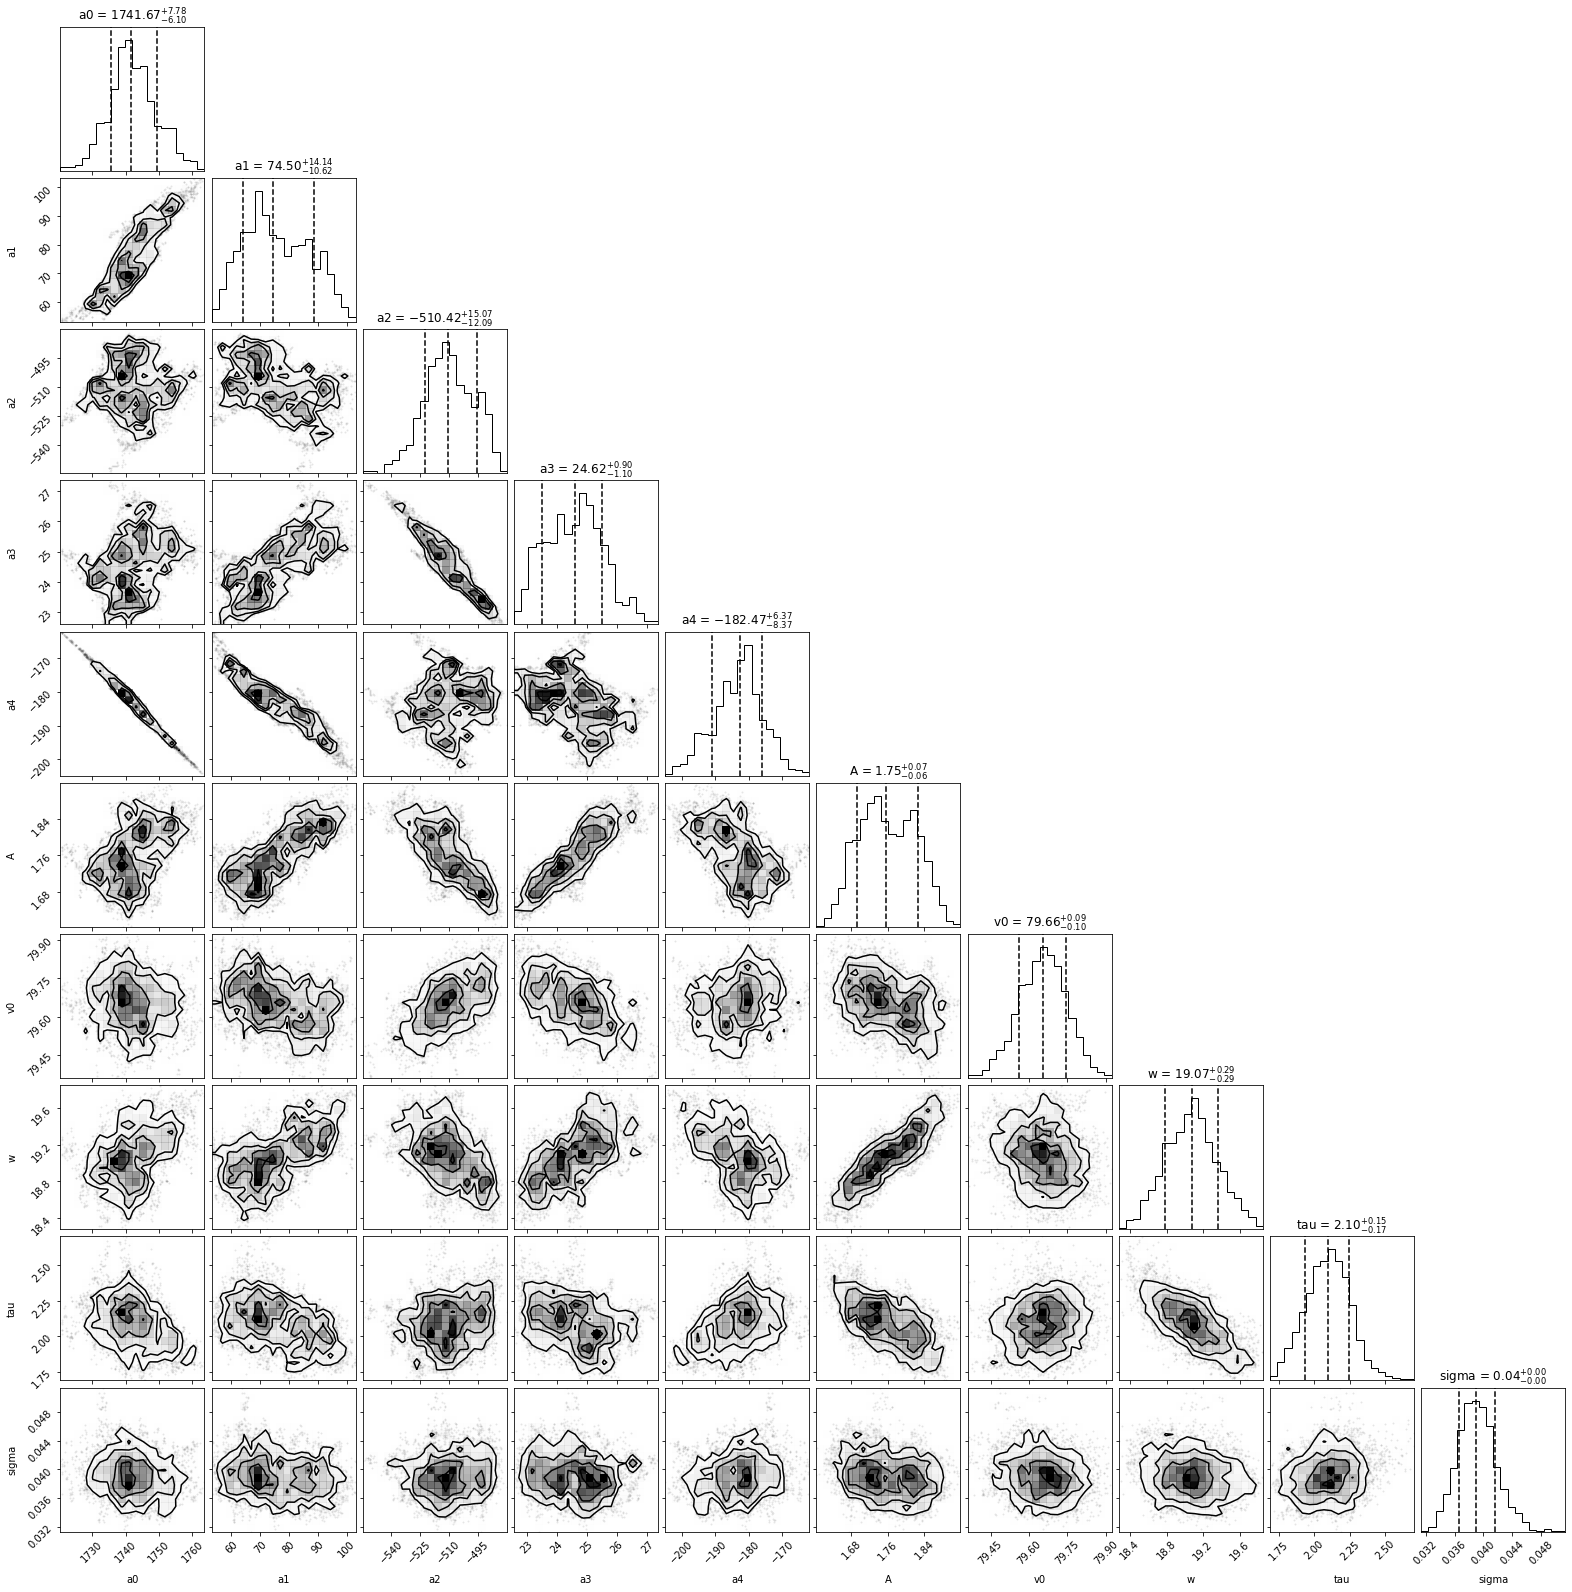

In [11]:
corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],show_titles=True) 
plt.show()